In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd drive/'My Drive'/'Colab Notebooks'/Rock-Paper-Scissor

/content/drive/My Drive/Colab Notebooks/Rock-Paper-Scissor


In [ ]:
#!unzip rock-paper-scissor.zip

In [ ]:
!ls

In [ ]:
import keras as k
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D , LeakyReLU
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import RMSprop,SGD,Adam
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
from tensorflow.keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
%matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
img_height = 100
img_width = 100
batch_size = 16

In [ ]:
data_image_gen = k.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5, 1.5],
    channel_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

train_data_generator = data_image_gen.flow_from_directory(
    'Dataset',
    subset='training',
    target_size=(img_height, img_width),
    color_mode="rgb", #grayscale
    shuffle=True,
    batch_size=batch_size,
    class_mode='categorical',
    seed=42
)

validation_data_generator = data_image_gen.flow_from_directory(
    'Dataset',
    subset='validation',
    target_size=(img_height, img_width),
    color_mode="rgb", #grayscale
    shuffle=True,
    batch_size=batch_size,
    class_mode='categorical',
    seed=42
)

Found 1980 images belonging to 3 classes.
Found 494 images belonging to 3 classes.


In [ ]:
unique, count = np.unique(train_data_generator.classes,return_counts=True)
print('train_dataset : samples per class')
print(dict(zip(train_data_generator.class_indices,count)))

unique, count = np.unique(validation_data_generator.classes,return_counts=True)
print('\nvalidation_dataset : samples per class')
dict(zip(validation_data_generator.class_indices,count))

train_dataset : samples per class
{'paper': 680, 'rock': 648, 'scissors': 652}

validation_dataset : samples per class


{'paper': 169, 'rock': 162, 'scissors': 163}

In [ ]:
def showImges(img_arr):
  fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(5,5))
  axes=axes.flatten()
  for img, ax in zip( img_arr, axes):
          ax.imshow(img)
          ax.axis('off')
  plt.tight_layout()
  plt.show()

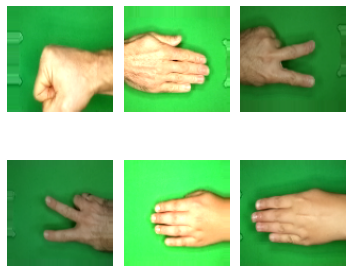

In [ ]:
sample_training_imgs,_=next(train_data_generator)
showImges(sample_training_imgs[:6])

In [ ]:
#custom model
x_input=Input((img_width,img_height,3))

x = Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='same',kernel_regularizer=k.regularizers.l2(0.0005),name='conv2d_1')(x_input)
x = BatchNormalization(epsilon=0.001, name='bnorm_1',axis=3)(x)
x = Activation('relu',name='acti_conv2d_1')(x)


x = MaxPooling2D((2, 2), name='max_pool')(x)

x = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='valid',kernel_regularizer=k.regularizers.l2(1e-4),name='conv2d_2')(x)
x = BatchNormalization(name='bnorm_2',axis=3)(x)
x = LeakyReLU(alpha=0.3,name='leaky_2')(x)

x = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',kernel_regularizer=k.regularizers.l2(1e-4),name='conv2d_3')(x)
x = BatchNormalization(name='bnorm_3',axis=3)(x)
x = LeakyReLU(alpha=0.3,name='leaky_3')(x)

x = AveragePooling2D((2, 2), name='avg_pool')(x)

x = Flatten()(x)

x = Dense(512,kernel_regularizer=k.regularizers.l2(1e-4), name='fc_1')(x)
x = LeakyReLU(alpha=0.3)(x)
# x = Dense(125, kernel_regularizer=k.regularizers.l2(1e-4), activation='relu' ,name='fc_2')(x)
x = Dense(3, kernel_regularizer=k.regularizers.l2(1e-4), activation='softmax' ,name='fc_2')(x)
# x = Activation('softmax',name='softmax_activation')(x)
model10 = Model(inputs = x_input, outputs = x, name='CustomModel')

In [ ]:
model10.summary()

Model: "CustomModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
bnorm_1 (BatchNormalization) (None, 100, 100, 32)      128       
_________________________________________________________________
acti_conv2d_1 (Activation)   (None, 100, 100, 32)      0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
bnorm_2 (BatchNormalization) (None, 48, 48, 64)        

In [ ]:
model10.compile(loss='categorical_crossentropy',metrics=['accuracy'],
              optimizer=SGD(learning_rate=0.01,momentum=0.9))

In [ ]:
model2_1.compile(loss='categorical_crossentropy',metrics=['accuracy'],
              optimizer=RMSprop())

model3.compile(loss='categorical_crossentropy',metrics=['accuracy'],
              optimizer=RMSprop())

model2.compile(loss='categorical_crossentropy',metrics=['accuracy'],
              optimizer=RMSprop())

model.compile(loss='categorical_crossentropy',metrics=['accuracy'],
              optimizer=Adam(learning_rate=0.01))

In [ ]:
hisory10_2 = model10.fit(
    train_data_generator,
    epochs=5,
    verbose=1,
    validation_data=validation_data_generator,
    shuffle=True,
)

Epoch 1/5
124/124 [==============================] - 19s 150ms/step - loss: 0.1933 - accuracy: 0.9783 - val_loss: 0.1315 - val_accuracy: 0.9757
Epoch 2/5
124/124 [==============================] - 17s 138ms/step - loss: 0.2211 - accuracy: 0.9717 - val_loss: 6.9145 - val_accuracy: 0.4231
Epoch 3/5
124/124 [==============================] - 17s 138ms/step - loss: 0.1931 - accuracy: 0.9788 - val_loss: 0.1289 - val_accuracy: 0.9555
Epoch 4/5
124/124 [==============================] - 17s 139ms/step - loss: 0.1860 - accuracy: 0.9788 - val_loss: 0.3280 - val_accuracy: 0.8178
Epoch 5/5
124/124 [==============================] - 17s 139ms/step - loss: 0.2167 - accuracy: 0.9712 - val_loss: 0.1407 - val_accuracy: 0.9514


In [ ]:
hisory10 = model10.fit(
    train_data_generator,
    epochs=50,
    verbose=1,
    validation_data=validation_data_generator,
    shuffle=True,
)

Epoch 1/50
124/124 [==============================] - 68s 548ms/step - loss: 2.4048 - accuracy: 0.4030 - val_loss: 1.1112 - val_accuracy: 0.5729
Epoch 2/50
124/124 [==============================] - 17s 136ms/step - loss: 1.2777 - accuracy: 0.5217 - val_loss: 0.7258 - val_accuracy: 0.6781
Epoch 3/50
124/124 [==============================] - 18s 146ms/step - loss: 0.9917 - accuracy: 0.6444 - val_loss: 0.9222 - val_accuracy: 0.7389
Epoch 4/50
124/124 [==============================] - 17s 137ms/step - loss: 0.8153 - accuracy: 0.7414 - val_loss: 0.7917 - val_accuracy: 0.7692
Epoch 5/50
124/124 [==============================] - 17s 136ms/step - loss: 0.7375 - accuracy: 0.7596 - val_loss: 0.5486 - val_accuracy: 0.8482
Epoch 6/50
124/124 [==============================] - 17s 136ms/step - loss: 0.7144 - accuracy: 0.7768 - val_loss: 0.6285 - val_accuracy: 0.7571
Epoch 7/50
124/124 [==============================] - 17s 138ms/step - loss: 0.6485 - accuracy: 0.8025 - val_loss: 0.5423 - val_ac

In [ ]:
history9=model9.fit(
    train_data_generator,
    epochs=50,
    verbose=1,
    validation_data=validation_data_generator,
    shuffle=True,
)

Epoch 1/50
117/117 [==============================] - 21s 176ms/step - loss: 1.5918 - accuracy: 0.4947 - val_loss: 1.1888 - val_accuracy: 0.5589
Epoch 2/50
117/117 [==============================] - 18s 158ms/step - loss: 0.9242 - accuracy: 0.6807 - val_loss: 0.5122 - val_accuracy: 0.7430
Epoch 3/50
117/117 [==============================] - 19s 160ms/step - loss: 0.8338 - accuracy: 0.7439 - val_loss: 1.7682 - val_accuracy: 0.7366
Epoch 4/50
117/117 [==============================] - 19s 164ms/step - loss: 0.7042 - accuracy: 0.8048 - val_loss: 0.3275 - val_accuracy: 0.8373
Epoch 5/50
117/117 [==============================] - 18s 157ms/step - loss: 0.6742 - accuracy: 0.8043 - val_loss: 0.2980 - val_accuracy: 0.8758
Epoch 6/50
117/117 [==============================] - 18s 157ms/step - loss: 0.5373 - accuracy: 0.8594 - val_loss: 0.4506 - val_accuracy: 0.8458
Epoch 7/50
117/117 [==============================] - 18s 157ms/step - loss: 0.5164 - accuracy: 0.8556 - val_loss: 0.3237 - val_ac

In [ ]:
history4=model4.fit(
    train_data_generator,
    epochs=20,
    verbose=1,
    validation_data=validation_data_generator,
    shuffle=True,
    callbacks=[
               EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True),
               ModelCheckpoint('weights_c.{epoch:02d}-{val_loss:.2f}.hdf5',monitor='val_loss',save_best_only=True,mode='auto')
    ]
)

Epoch 1/20
110/110 [==============================] - 17s 156ms/step - loss: 0.8649 - accuracy: 0.7019 - val_loss: 1.5455 - val_accuracy: 0.3318
Epoch 2/20
110/110 [==============================] - 16s 143ms/step - loss: 0.7095 - accuracy: 0.8658 - val_loss: 1.2949 - val_accuracy: 0.3707
Epoch 3/20
110/110 [==============================] - 16s 144ms/step - loss: 0.6483 - accuracy: 0.9246 - val_loss: 0.7611 - val_accuracy: 0.5652
Epoch 4/20
110/110 [==============================] - 16s 144ms/step - loss: 0.6346 - accuracy: 0.9400 - val_loss: 1.2840 - val_accuracy: 0.5217
Epoch 5/20
110/110 [==============================] - 17s 150ms/step - loss: 0.6258 - accuracy: 0.9429 - val_loss: 1.2695 - val_accuracy: 0.6613
Epoch 6/20
110/110 [==============================] - 16s 142ms/step - loss: 0.6167 - accuracy: 0.9503 - val_loss: 0.6603 - val_accuracy: 0.8421
Epoch 7/20
110/110 [==============================] - 16s 145ms/step - loss: 0.6094 - accuracy: 0.9572 - val_loss: 0.7430 - val_ac

In [ ]:
model10.save('model10.h5')
model10.save_weights('model10.h5')

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


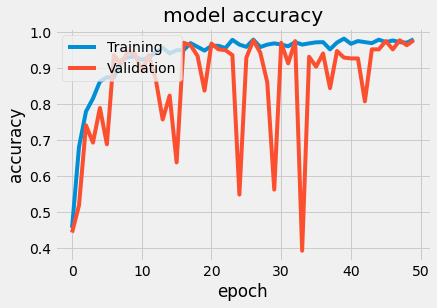

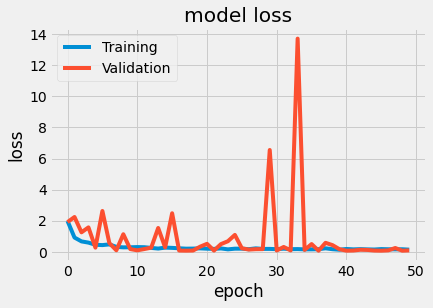

In [ ]:
print(history10.history.keys())

plt.style.use('fivethirtyeight')
# summarize history for accuracy
plt.plot(history6.history['accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [ ]:
inception_base = k.applications.ResNet50(weights='imagenet',input_shape=(100,100,3), include_top=False)

x = inception_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)
inception_transfer = Model(inputs=inception_base.input, outputs=predictions)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 8s 0us/step


In [ ]:
inception_transfer.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=1e-4,momentum=0.9),
              metrics=['accuracy'])

In [ ]:
with tf.device("/device:GPU:0"):
    history_pretrained = inception_transfer.fit(
    train_data_generator,
    epochs = 25, 
    shuffle = True, 
    verbose = 1, 
    validation_data = validation_data_generator)

Epoch 1/25
124/124 [==============================] - 34s 276ms/step - loss: 0.6721 - accuracy: 0.7374 - val_loss: 2.8568 - val_accuracy: 0.3421
Epoch 2/25
124/124 [==============================] - 22s 180ms/step - loss: 0.2486 - accuracy: 0.9404 - val_loss: 12.8339 - val_accuracy: 0.3421
Epoch 3/25
124/124 [==============================] - 22s 180ms/step - loss: 0.1492 - accuracy: 0.9677 - val_loss: 11.4814 - val_accuracy: 0.3421
Epoch 4/25
124/124 [==============================] - 22s 179ms/step - loss: 0.0963 - accuracy: 0.9818 - val_loss: 15.8154 - val_accuracy: 0.3421
Epoch 5/25
124/124 [==============================] - 22s 179ms/step - loss: 0.0694 - accuracy: 0.9833 - val_loss: 11.5640 - val_accuracy: 0.3482
Epoch 6/25
124/124 [==============================] - 22s 180ms/step - loss: 0.0551 - accuracy: 0.9869 - val_loss: 3.5464 - val_accuracy: 0.3785
Epoch 7/25
124/124 [==============================] - 22s 180ms/step - loss: 0.0504 - accuracy: 0.9909 - val_loss: 0.3221 - va

In [ ]:
import os

In [ ]:
x=cv2.imread('Dataset/rock/01dM3ewPIsnBICu1.png')
x=cv2.resize(x,(100,100))
x = x / 255
img_arr=np.array(x)
img = np.array([img_arr])
print(img.shape)
y=model6.predict(img)
print(np.max(y))
print(np.argmax(y,axis=1))
print(os.listdir('Dataset')[np.argmax(y,axis=1)[0]])


(1, 100, 100, 3)
1.0
[1]
rock


In [ ]:
x=cv2.imread('Dataset/scissors/1VRzspyXpQ6A2rKy.png')
x=cv2.resize(x,(100,100))
x = x / 255
img_arr=np.array(x)
img = np.array([img_arr])
print(img.shape)
y=model5.predict(img)
print(np.max(y))
print(np.argmax(y,axis=1))
print(os.listdir('Dataset')[np.argmax(y,axis=1)[0]])


(1, 100, 100, 3)
0.9999989
[2]
scissors


In [ ]:
# after error
x=cv2.imread('Dataset/scissors/1VRzspyXpQ6A2rKy.png')
x=cv2.resize(x,(100,100))
x = x / 255
img_arr=np.array(x)
img = np.array([img_arr])
print(img.shape)
y=model9.predict(img)
print(np.max(y))
print(np.argmax(y,axis=1))
print(os.listdir('Dataset')[np.argmax(y,axis=1)[0]])

(1, 100, 100, 3)
0.9994955
[2]
scissors


In [ ]:
all_imgs = []
imgs = os.listdir('Dataset/scissors')
imgs = imgs[10:20]
for img in imgs:
  x = cv2.imread('Dataset/scissors/' + img, 3)
  x=cv2.resize(x,(100,100))
  x = np.array(x) / 255
  all_imgs.append(x)
all_imgs = np.array(all_imgs)


y=model5.predict(x=all_imgs)
for e in y:
  print(np.argmax(e))

2
2
2
2
2
2
2
2
2
2


In [ ]:
#try
x=cv2.imread('/content/images.jpg')
x = cv2.cvtColor(x,cv2.COLOR_BGR2RGB)
x=cv2.resize(x,(100,100))
x = x / 255
img_arr=np.array(x)
img = np.array([img_arr])
print(img.shape)
y=model9.predict(img)
print(np.max(y))
print(np.argmax(y,axis=1))
print(os.listdir('Dataset')[np.argmax(y,axis=1)[0]])
y

(1, 100, 100, 3)
0.99999905
[1]
rock


array([[1.6498274e-07, 9.9999905e-01, 8.5180091e-07]], dtype=float32)

In [ ]:
# inception transfer model
x=cv2.imread('/content/images.jpg')
x = cv2.cvtColor(x,cv2.COLOR_BGR2RGB)
x=cv2.resize(x,(100,100))
x = x / 255
img_arr=np.array(x)
img = np.array([img_arr])
print(img.shape)
y=inception_transfer.predict(img)
print(np.max(y))
print(np.argmax(y,axis=1))
print(os.listdir('Dataset')[np.argmax(y,axis=1)[0]])
y

(1, 100, 100, 3)
0.9337198
[1]
rock


array([[0.02038304, 0.9337198 , 0.04589712]], dtype=float32)

In [ ]:
# after error
x=cv2.imread('Dataset/paper/4484TuJc6AH7pDOG.png')
x=cv2.resize(x,(100,100))
x = x / 255
img_arr=np.array(x)
img = np.array([img_arr])
print(img.shape)
y=model9.predict(img)
print(np.max(y))
print(np.argmax(y,axis=1))
print(os.listdir('Dataset')[np.argmax(y,axis=1)[0]])
y

(1, 100, 100, 3)
0.965744
[2]
scissors


array([[0.03069577, 0.0035602 , 0.965744  ]], dtype=float32)

In [ ]:
# inception transfer model
x=cv2.imread('Dataset/paper/4484TuJc6AH7pDOG.png')
x=cv2.resize(x,(100,100))
x = x / 255
img_arr=np.array(x)
img = np.array([img_arr])
print(img.shape)
y=inception_transfer.predict(img)
print(np.max(y))
print(np.argmax(y,axis=1))
print(os.listdir('Dataset')[np.argmax(y,axis=1)[0]])
y

(1, 100, 100, 3)
0.99992025
[0]
paper


array([[9.9992025e-01, 4.6758258e-05, 3.2994190e-05]], dtype=float32)

In [ ]:
all_imgs = []
imgs = os.listdir('Dataset/paper')
imgs = imgs[:10]
for img in imgs:
  x = cv2.imread('Dataset/paper/' + img, 3)
  x=cv2.resize(x,(100,100))
  x = np.array(x) / 255
  all_imgs.append(x)
all_imgs = np.array(all_imgs)


y=model5.predict(x=all_imgs)
for e in y:
  print(np.argmax(e))

0
2
0
0
0
0
0
0
0
0


In [ ]:
# inception transfer model
all_imgs = []
imgs = os.listdir('Dataset/paper')
imgs = imgs[:10]
for img in imgs:
  x = cv2.imread('Dataset/paper/' + img, 3)
  x=cv2.resize(x,(100,100))
  x = np.array(x) / 255
  all_imgs.append(x)
all_imgs = np.array(all_imgs)


y=inception_transfer.predict(x=all_imgs)
for e in y:
  print(np.argmax(e))

0
0
0
0
0
0
0
0
0
0


In [ ]:
#err
all_imgs = []
imgs = os.listdir('Dataset/scissors')
imgs = imgs[50:60]
for img in imgs:
  x = cv2.imread('Dataset/scissors/' + img, 3)
  x=cv2.resize(x,(100,100))
  x = np.array(x) / 255
  all_imgs.append(x)
all_imgs = np.array(all_imgs)


y=model9.predict(x=all_imgs)
for e in y:
  print(np.argmax(e))

2
2
2
2
2
2
2
2
2
2


In [ ]:
# inception transfer model
all_imgs = []
imgs = os.listdir('Dataset/scissors')
imgs = imgs[50:60]
for img in imgs:
  x = cv2.imread('Dataset/scissors/' + img, 3)
  x=cv2.resize(x,(100,100))
  x = np.array(x) / 255
  all_imgs.append(x)
all_imgs = np.array(all_imgs)


y=inception_transfer.predict(x=all_imgs)
for e in y:
  print(np.argmax(e))

2
2
2
2
2
2
2
2
2
2


In [ ]:
all_imgs = []
imgs = os.listdir('Dataset/rock')
imgs = imgs[:10]
for img in imgs:
  x = cv2.imread('Dataset/rock/' + img, 3)
  x=cv2.resize(x,(100,100))
  x = np.array(x) / 255
  all_imgs.append(x)
all_imgs = np.array(all_imgs)

y=model5.predict(x=all_imgs)
for e in y:
  print(np.argmax(e))

1
1
1
1
1
1
1
1
1
1


In [ ]:
# inception transfer model
all_imgs = []
imgs = os.listdir('Dataset/rock')
imgs = imgs[:10]
for img in imgs:
  x = cv2.imread('Dataset/rock/' + img, 3)
  x=cv2.resize(x,(100,100))
  x = np.array(x) / 255
  all_imgs.append(x)
all_imgs = np.array(all_imgs)

y=inception_transfer.predict(x=all_imgs)
for e in y:
  print(np.argmax(e))

1
1
1
1
1
1
1
1
1
1


In [ ]:
!mkdir final_tflite

In [ ]:
new_model= tf.keras.models.load_model(filepath="model10.h5")
new_model.load_weights('model10.h5')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

38108588